# Лабораторная работа №3

**Тема: "Апериодические сигналы"**

Работу выполнил

студент группы 5130901/20201

Нестеренко Сергей Андреевич

---

In [23]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

from thinkdsp import Chirp, PI2, normalize, unbias, read_wave
import numpy as np

## Упражнение 3.1

В файле **chap03.ipynb** обозреваются такие элементы библиотеки `ThinkDSP`, как класс `Chirp`, функция `hamming`, вычисляющая окно Хэмминга, а также спектрограммы. 

Ниже рассмотрен пример с утечкой, аналогичный представленному в **chap03.ipynb**, однако для борьбы с утечкой использовано окно Бартлетта.

Создадим сегмент с дробным числом периодов. На графике увидим явную утечку спектра.

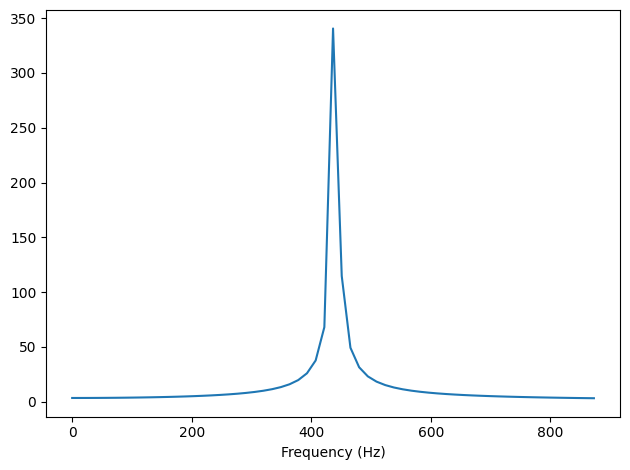

In [13]:
import numpy as np
from thinkdsp import SinSignal, decorate
signal = SinSignal(freq=440)
duration = signal.period * 30.25
wave = signal.make_wave(duration)
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)')

Теперь вместо окна Хэмминга применим к сигналу окно Барлетта. Увидим результат, отличный от представленного в примере. Утечка устранена частично -- слева и справа от главного пика наблюдается множество пологих пиков, спадающих при движении от 440 Гц.

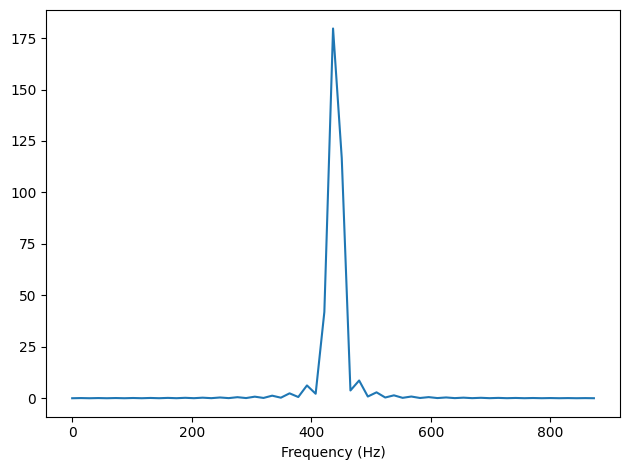

In [14]:
wave.ys *= np.bartlett(len(wave.ys))
spectrum = wave.make_spectrum()
spectrum.plot(high=880)

decorate(xlabel='Frequency (Hz)')

## Упражнение 3.2

Реализуем класс `SawtoothChirp`, расширяющий `Crirp` и переопределяющий `evaluate` для генерации пилообразного сигнала с линейно увеличивающейся (или уменьшающейся) частотой.

In [15]:
class SawtoothChirp(Chirp):
    def evaluate(self, ts):
        freqs = np.linspace(self.start, self.end, len(ts))
        dts = np.diff(ts, prepend=0)
        dphis = PI2 * freqs * dts
        phases = np.cumsum(dphis)
        cycles = phases / PI2
        frac, _ = np.modf(cycles)
        ys =  normalize(unbias(frac), self.amp)
        return ys

Нарисуем эскиз спектрограммы полученного сигнала.

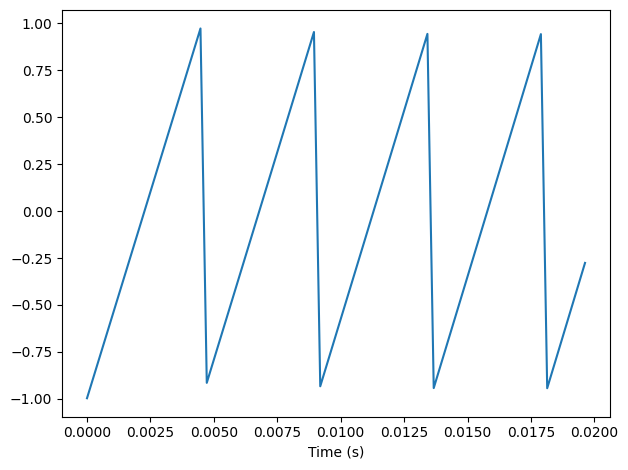

In [16]:
signal = SawtoothChirp(start=220, end=440)
wave = signal.make_wave(duration=1, framerate=4025)
wave.segment(start=0, duration=0.02).plot() 
decorate(xlabel='Time (s)')

Прослушаем полученный сигнал. На фоне слышны едва различимые биения.

In [17]:
wave.make_audio()

Выведем спектрограмму сигнала. На ней уже явно видны те самые биения.

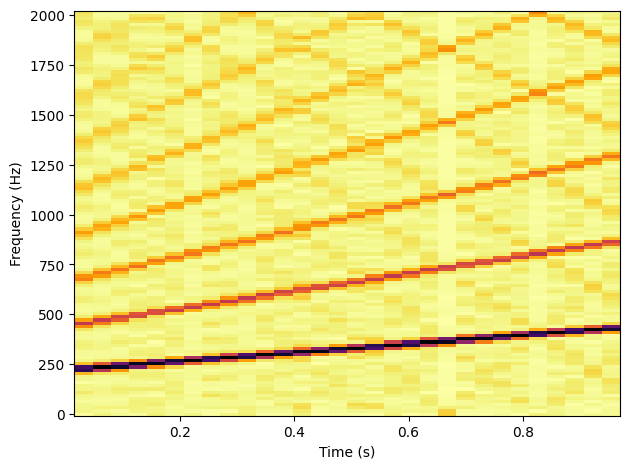

In [18]:
sp = wave.make_spectrogram(256)
sp.plot()
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

## Упражнение 3.3

Создадим пилообразный чирп, меняющийся от 2500 Гц до 3000 Гц. На его основе сгенерируем сигнал длительностью 1 с и частотой кадров 20 кГц.

In [19]:
new_stchirp = SawtoothChirp(start=2500, end=3000)
new_stwave = new_stchirp.make_wave(duration=1, framerate=20000)
new_stwave.make_audio()

Получим `Spectrum` этого сигнала. 

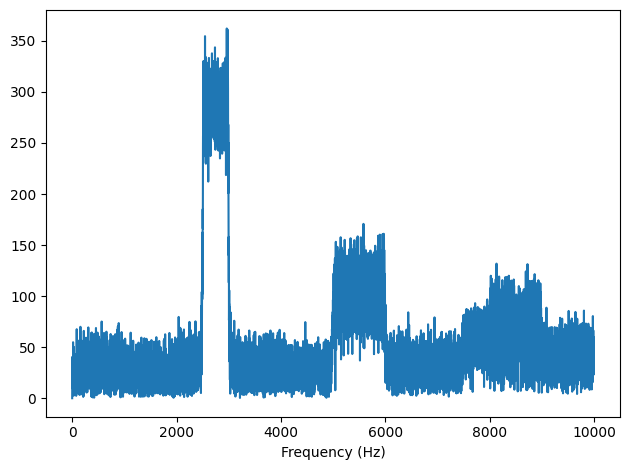

In [20]:
new_stwave.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)')

## Упражнение 3.4

Рассмотрим начало композиции "Rhapsody in Blue", в котором присутствует глиссандо.

In [26]:
glissando_wave = read_wave(filename='./audio/rhapblue.wav')
glissando_wave.make_audio()

На спектрограмме отчетливо видно, как в первые 2.5 секунды частота плавно нарастает, что соответствует действительности.

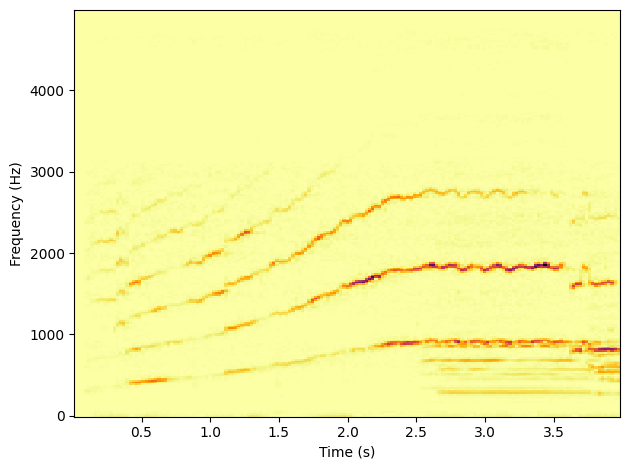

In [37]:
glissando_wave.segment(start=0, duration=4).make_spectrogram(512).plot(high=5000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

## Упражнение 3.5

Если тромбонист играет глиссандо, двигая кулису с постоянной скоростью, частота во времени будет изменяться пропорционально $\left. 1 \middle/ f \right. \\[1em]$.

Создадим класс `TromboneGliss`, расширяющий `Chirp` и предоставляющий `evaluate`.

In [38]:
class TromboneGliss(Chirp):
    def evaluate(self, ts):
        l1, l2 = 1.0 / self.start, 1.0 / self.end
        lengths = np.linspace(l1, l2, len(ts))
        freqs = 1 / lengths
        
        dts = np.diff(ts, prepend=0)
        dphis = PI2 * freqs * dts
        phases = np.cumsum(dphis)
        ys = self.amp * np.cos(phases)
        return ys

Создадим сигнал, имитирующий глиссандо на тромбоне от C3 (262 Гц) до F3 и обратно. Если сравнить его звучание с линейным и экспоненциальным чирпами, то получится нечто среднее.

In [39]:
c3 = 262
f3 = 349
c3f3c3 = TromboneGliss(c3, f3).make_wave(duration=1) | TromboneGliss(f3, c3).make_wave(duration=1)
c3f3c3.make_audio()

Также построим спектрограмму полученного сигнала. На ней видно, как частота сигнала сначала возрастает, а потом убывает. Видно, что изменение частоты имеет нелинейный характер, однако скорость изменения возрастает не так быстро, как в случае с экспоненциальным чирпом.

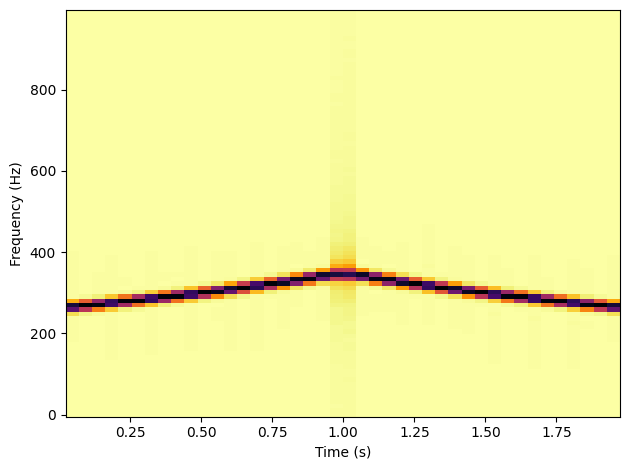

In [41]:
c3f3c3.make_spectrogram(1024).plot(high=1000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

## Упражнение 3.6

Из открытых источников взят аудиофайл, в котором различные люди произносят гласные звуки.

In [44]:
vowels = read_wave(filename='./audio/a-e-i-o-u.wav')
vowels.make_audio()

Выведем спектрограммы для обеих серий гласных звуков.

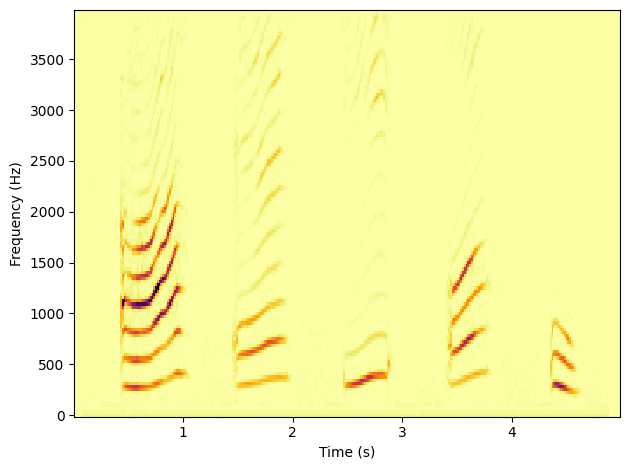

In [58]:
vowels.segment(start=0, duration=5).make_spectrogram(256).plot(high=4000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

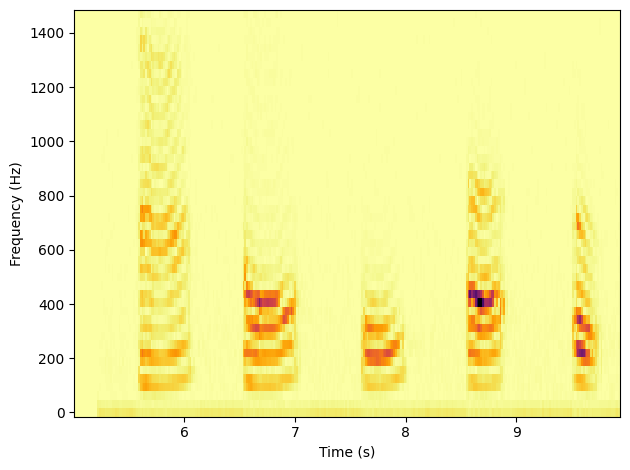

In [59]:
vowels.segment(start=5, duration=5).make_spectrogram(256).plot(high=1500)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

Из полученных результатов видно, что одинаковые гласные звуки, произносимые разными людьми, похожи между собой на спектрограмме, несмотря на существенные различия в тембре, высоте голоса. Например, звук \[а\] задействует широкий диапазон частот, а звук \[и\] -- узкий, с преобладанием низких частот. В звуке \[о\] сильнее всего выделяются средние частоты. Также каждый звук на спектрограмме имеер уникальную форму.

Зная эти различия, можно разрабатывать технологии перевода речи в текст, синтезировать речь, создавать голосовых помощников и многое другое.